In [3]:
import matplotlib.pyplot as plt
import stompy.model.delft.dflow_model as dfm
import stompy.model.hydro_model as hm
import xarray as xr
from stompy import utils
import numpy as np
import os
import pandas as pd
from stompy.plot import plot_wkb, plot_utils

import six

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib notebook

In [4]:
import sfb_csc

In [5]:
runs=[
    #dict(run_dir="data_3d_2019_summer-v009", label="3D"),
    #dict(run_dir="data_2d_2019_summer-v008", label="2D"),
    # switch tides to PR
    #dict(run_dir="data_2d_2019_summer-v010", label="2D"),
    # in progress:
    # v011: use that last run to set lag and amplitude at SF
    #dict(run_dir="data_2d_2019_summer-v011", label="2D"),
    #dict(run_dir="data_2d_2019_summer-v012", label="2D"),
    # v012: bring the old tuned roughness back in. Had been
    #   running [accidentally] with uniform 0.02 roughness
    # v015: more roughness everywhere
    #dict(run_dir="data_2d_2019_summer-v015", label="2D"),
    # v016: bedlevtype=3. WSE amplitude about the same, lag
    # got worse.
    # dict(run_dir="data_2d_2019_summer-v016", label="2D"),
    # v017: bedlevtype=4 
    # Similarly bad for lag.
    # dict(run_dir="data_2d_2019_summer-v017", label="2D"),
    # v019: extract bathy at nodes, no bias. Lags are better
    # than v016, v017, but not good.
    #dict(run_dir="data_2d_2019_summer-v019", label="2D"),
    # v020: keep node sampling but go back to bedlevtype=6
    # This is getting pretty close. Can decrease friction some
    # throughout the Bay. And check the lag code to see if it
    #  is using R or R^2. It's coming up with ~6+h lags, and negative
    #  r.
    # dict(run_dir="data_2d_2019_summer-v020", label="2D"),
    # v021: reduce global friction to 0.023. Deep bias in intertidal
    # areas, direct sample in subtidal areas. Fix the sign on
    # some transects. No change in ocean lag/amplitude, but that's probably
    # needed.
    #dict(run_dir="data_2d_2019_summer-v021", label="2D"),
    # v022: minor tweak to amplitude, phase of BC. also slight decrease in
    # sac, south delta, south bay friction
    # dict(run_dir="data_2d_2019_summer-v022", label="2D"),
    # v023: various tweaks to friction, and fix the sign issue with the 
    # lag.
    
    # Calibration period
    dict(run_dir="data_2d_2019_summer-v023", label="2D")
    # Validation period
    #dict(run_dir="data_2d_2018_hybrid-v008", label="2D")
]
runs=pd.DataFrame(runs)

In [6]:
six.moves.reload_module(dfm)
six.moves.reload_module(sfb_csc)

runs['model'] = runs['run_dir'].apply(lambda r: sfb_csc.SfbCsc.load(r))

In [7]:
# Dev for stage comparisons
his_ds=runs.loc[0,'model'].his_dataset()


In [8]:
fig_dir=os.path.join(runs['run_dir'].values[0],'figures')
dpi=150
fig_dir

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    

In [9]:
# cross_section geom is coming up strange. Either a bug in DFM snapping or
# output. Some of the coordinates are zero in the hist file.

In [10]:
import stompy.model.data_comparison as dc
six.moves.reload_module(dc)

# If a period has been fetched before these can be set to True
# to speed up the process.
six.moves.reload_module(hm)
hm.NwisStageBC.cache_only = True
hm.NwisFlowBC.cache_only = True

class ModelData: 
    data_start=None # will be set from model
    data_stop =None
    spinup = np.timedelta64(7,'D')

    def __init__(self,model,**kw):
        utils.set_keywords(self,kw)
        # Might transition this to better caching at some point.
        self.model=model
        self.his=self.model.his_dataset()
        self.data_start=self.his.time.values[0] + self.spinup
        self.data_stop =self.his.time.values[-1]


class DFMStage(ModelData):
    station=None
    vertical_datum='NAVD88'
    
    def __init__(self,model,station):
        super().__init__(model)
        self.station=station
        
    def src_data(self):
        if self.station not in self.his.stations:
            print(f"stations={self.station} not present in his file")
            return None

        da=self.his.sel(stations=self.station)['waterlevel']
        da=da.assign_coords(label='Pred')
        da.attrs['vertical_datum']=self.vertical_datum
        da=da.sel(time=da.time>=self.data_start) # for spinup
        return da
    
    def plot_xy(self):
        if self.station not in self.his.stations: return None
        return [self.his.station_x_coordinate.sel(stations=self.station).values,
                self.his.station_y_coordinate.sel(stations=self.station).values]
    
class DFMFlow(ModelData):
    cross_section=None
    location=None
    
    def __init__(self,model,cross_section,**kw):
        self.cross_section=cross_section
        super().__init__(model,**kw)
        
    def src_data(self):
        if self.cross_section not in self.his.cross_section:
            print(f"cross_section={self.cross_section} not present in his file")
            return None
        da=self.his.sel(cross_section=self.cross_section)['cross_section_discharge']
        da=da.assign_coords(label='Pred')
        da=da.sel(time=da.time>=self.data_start) # for spinup
        return da
    
    def plot_xy(self):
        if self.location is None:
            if self.cross_section not in self.his.cross_section: return None
            linestring=self.his.cross_section_geom.sel(cross_section=self.cross_section).item()
            #return np.array(linestring.coords).mean(axis=0)
            return np.array(linestring.coords)[0,:] # some features have trailing 0?
        elif isinstance(self.location,str):
            # interpret as a station with the given name
            if self.location not in self.his.stations: return None
            return [self.his.station_x_coordinate.sel(stations=self.location).values,
                    self.his.station_y_coordinate.sel(stations=self.location).values]
        else: # assume [x,y]
            return self.location
        
class StationCompare:
    """
    Comparison plots and helpers for station-oriented data
    """
    name=None
    reference=0 # control metric calculation 
    predicted=1 # 
    ylabel=None
    
    def __init__(self,sources,**kw):
        self.sources=sources
        self.data=None
        utils.set_keywords(self,kw)
        
        if self.name is None:
            self.name=self.sources[0].name    
        
    def plot_xy(self):
        """
        return [x,y] for where this point[ish] comparison should be
        plotted.
        """
        for source in self.sources:
            try:
                xy=source.plot_xy()
                if xy is not None:
                    return xy
            except AttributeError:
                pass
        print("No sources provided a location")
        return [np.nan,np.nan]
        
    def assemble_data(self):
        if self.data is not None:
            return self.data
        
        # See which sources already have a date range.
        # choose the final date range based on those.
        starts=[]
        stops =[]
        for source in self.sources:
            if source.data_start is not None:
                starts.append(source.data_start)
            if source.data_stop is not None:
                stops.append(source.data_stop)
        # will need better logic than this. Maybe test for model vs obs.
        start=min(starts)
        stop =max(stops)
        print(f"Inferred time period: {start} to {stop}")
        
        data=[]
        
        labels={}
        for src_i,source in enumerate(self.sources):
            if source.data_start is None:
                source.data_start=start
            if source.data_stop is None:
                source.data_stop =stop
            try:
                da=source.src_data()
            except hm.MissingBCData:
                da=None

            if da is None:
                data.append(None)
                continue
                
            if 'label' not in da.coords:
                if isinstance(source,hm.BC):
                    label="Obs"
                elif isinstance(source,ModelData):
                    label="Pred"
            else:
                label=da.label.item()
                
            if label in labels:
                label=label+str(src_i)
            labels[label]=True
            data.append(da.assign_coords(label=label))
        self.data=data
        return self.data
    
    def calc_metrics(self):
        data=self.assemble_data() # list of dataarrays
        if data[self.reference] is None or data[self.predicted] is None:
            return dict(error="no data")
        else:
            return dc.calc_metrics(data[self.predicted],data[self.reference],combine=True)

    def figure(self,fig=None):
        self.assemble_data()
        if any([d is None for d in self.data]):
            print("No data - skipping figure")
            return None
        self.combined=dc.combine_sources(self.data)
        # Not currently set up to understand self.vertical_datum
        fig=dc.calibration_figure_3panel(all_sources=self.data,
                                         metric_x=self.predicted,metric_ref=self.reference,
                                         combined=self.combined,fig=fig,ylabel=self.ylabel)
        fig.axes[0].legend(title=self.name,loc='upper left',bbox_to_anchor=(1,1),
                           frameon=0)
        fig.subplots_adjust(right=0.74,left=0.07,top=0.98,bottom=0.02)
        return fig
    def figure_name(self):
        return self.name

class StageCompare(StationCompare):
    vertical_datum=None # will get set by assemble_data
    ylabel="Stage (m)"
    
    # Should check any Nwis stations for vertical_datum
    def assemble_data(self):
        if self.data is not None:
            return self.data

        super().assemble_data()

        vertical_datums = [ (da.attrs['vertical_datum'] if (da is not None) else None)
                           for da in self.data]
        if all( [vd==vertical_datums[0] for vd in vertical_datums]):
            self.vertical_datum = vertical_datums[0]
        else:
            print("Removing mean for mismatched vertical datums")
            for i,da in enumerate(self.data):
                if da is not None:
                    da=da - da.mean().item()
                    self.data[i] = da
            self.vertical_datum='n/a'
        return self.data
    def calc_metrics(self):
        metrics = super().calc_metrics()
        if self.vertical_datum in [None,'n/a'] and 'bias' in metrics:
            metrics['bias']=np.nan
        return metrics
    
    def figure_name(self):
        return f"stage-{self.name}"

class FlowCompare(StationCompare):
    ylabel="Flow (m3 s-1)"
    def figure_name(self):
        return f"flow-{self.name}"


hm.NwisStageBC.cache_dir="cache"
hm.NOAAStageBC.cache_dir="cache"

# maybe a more generic way
comparisons=[
    StageCompare( [ hm.NwisStageBC(11455420,name='SRV', vertical_datum='NAVD88') ]
                 + [DFMStage(model,'SRV') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    FlowCompare( [ hm.NwisFlowBC(11455420,name='SRV') ]
                 + [DFMFlow(model,'RioVista') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    

    StageCompare( [ hm.NwisStageBC(11447650,name='FPT', vertical_datum='n/a') ]
                 + [DFMStage(model,'FPX') for model in runs['model']],
                 name="Freeport"),

    FlowCompare( [ hm.NwisFlowBC(11447650,name="FPT") ]
               + [DFMFlow(model,"Freeport") for model in runs['model']],
               name="Freeport"),
    
    StageCompare( [ hm.NwisStageBC(11455385,name='RYI', vertical_datum='NAVD88') ]
                 + [DFMStage(model,'RYI') for model in runs['model']],
                 name="RYI (near match)"),

    # Stage for 2020 to 2023. Has EC much earlier.
    #StageCompare( [ hm.NwisStageBC(11455280,name='HST') ]
    #             + [DFMStage(model,'HST') for model in runs['model']],
    #             name="HST"),

    # Hass near Elmira. Newly added observation point.
    #StageCompare( [ hm.NwisStageBC(11455278,name="HAS") ]
    #             + {DFMStage(model, 'HassElmira') for model in runs['model']],
    #               name="HAS"}
    
    # Newly added station
    StageCompare( [hm.NwisStageBC(11313433, name="DutchSlough", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Newly added section
    FlowCompare( [hm.NwisFlowBC(11313433, name="DutchSlough")]
                 + [DFMFlow(model, 'DSL', location='DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Jersey Point 
    StageCompare( [hm.NwisStageBC(11337190, name="JerseyPoint", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'JPT') for model in runs['model']],
                 name="Jersey Point"),
    FlowCompare( [hm.NwisFlowBC(11337190, name="JerseyPoint")]
                 + [DFMFlow(model, 'JPT',location='JPT') for model in runs['model']],
                 name="Jersey Point"),
    
    # Threemile Slough 
    StageCompare( [hm.NwisStageBC(11337080, name="ThreemileSlough", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'TSL') for model in runs['model']],
                 name="Threemile Slough"),
    FlowCompare( [hm.NwisFlowBC(11337080, name="ThreemileSlough")]
                 + [DFMFlow(model, 'TSL',location='TSL') for model in runs['model']],
                 name="Threemile Slough"),
    
    # Delta Cross Channel
    StageCompare( [hm.NwisStageBC(11336600, name="DeltaCrossChannel", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'DLC') for model in runs['model']],
                 name="Delta Cross Channel"),
    FlowCompare( [hm.NwisFlowBC(11336600, name="DeltaCrossChannel")]
                 + [DFMFlow(model, 'DLC') for model in runs['model']],
                 name="Delta Cross Channel"),
    
    # Sac below Georgiana
    StageCompare( [hm.NwisStageBC(11447905, name="SacBelowGeorgiana", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    FlowCompare( [hm.NwisFlowBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMFlow(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    
    # Georgiana Sl at Sac River
    StageCompare( [hm.NwisStageBC(11447903, name="Georgiana Sl", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    FlowCompare( [hm.NwisFlowBC(11447903, name="Georgiana Sl")]
                 + [DFMFlow(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    
    # Sac above DCC
    StageCompare( [hm.NwisStageBC(11447890, name="Sac ab DCC", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    FlowCompare( [hm.NwisFlowBC(11447890, name="Sac ab DCC")]
                 + [DFMFlow(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    
    # Prisoners Point
    StageCompare( [hm.NwisStageBC(11313460, name="SJ Prisoners Pt", vertical_datum='n/a')]
                 + [DFMStage(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),
    FlowCompare( [hm.NwisFlowBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMFlow(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),

    # Garwood Bridge 
    StageCompare( [hm.NwisStageBC(11304810, name="SJ Garwood Br", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    FlowCompare( [hm.NwisFlowBC(11304810, name="SJ Garwood Br")]
                 + [DFMFlow(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    
    # Victoria Canal
    StageCompare( [hm.NwisStageBC(11312672, name="Victoria Canal", vertical_datum='n/a')]
                 + [DFMStage(model, 'VCU') for model in runs['model']],
                 name="Victoria Canal"),
    FlowCompare( [hm.NwisFlowBC(11312672, name="Victoria Canal")]
                 + [DFMFlow(model, 'VCU') for model in runs['model']],
                 name="Victoria Canal"),
    
    # Old River at Byron
    StageCompare( [hm.NwisStageBC(11313315, name="Old River at Byron", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'ORB') for model in runs['model']],
                 name="Old River at Byron"),
    FlowCompare( [hm.NwisFlowBC(11313315, name="Old River at Byron")]
                 + [DFMFlow(model, 'ORB') for model in runs['model']],
                 name="Old River at Byron"),
    
    #  Steamboat slough near Walnut Grove
    StageCompare( [hm.NwisStageBC(11447850, name="Steamboat Sl nr Walnut Grove", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'SSS') for model in runs['model']],
                 name="Steamboat Sl nr Walnut Gr"),
    FlowCompare( [hm.NwisFlowBC(11447850, name="Steamboat Sl nr Walnut Grove")]
                 + [DFMFlow(model, 'SSS') for model in runs['model']],
                 name="Steamboat Sl nr Walnut Gr"),

    #  Sutter nr courtland
    StageCompare( [hm.NwisStageBC(11447830, name="Sutter Sl a Courtland", vertical_datum='NAVD88')]
                 + [DFMStage(model, 'SUT') for model in runs['model']],
                 name="Sutter Sl at Courtland"),
    FlowCompare( [hm.NwisFlowBC(11447830, name="Sutter Sl a Courtland")]
                 + [DFMFlow(model, 'SUT') for model in runs['model']],
                 name="Sutter Sl at Courtland"),
    
    ##  DWSC near Freeport - stage and discharge start in 2020
    #StageCompare( [hm.NwisStageBC(11455095, name="Deep Water SC nr Freeport")]
    #             + [DFMStage(model, 'FIXME') for model in runs['model']],
    #             name="DWSC nr Freeport"),
    #FlowCompare( [hm.NwisFlowBC(11455095, name="Deep Water SC nr Freeport")]
    #             + [DFMFlow(model, 'FIXME') for model in runs['model']],
    #             name="DWSC nr Freeport"),
    
    
    
    
    
    # TempCompare(11455142 Deep water ship channel)
    # SalinityCompare(11455142 Deep water ship channel)
    
    StageCompare( [hm.NwisStageBC(11455276,name="SHAG", vertical_datum='NAVD88') ]
                 + [DFMStage(model,"SG1") for model in runs['model']],
                 name="SHAG"),
    
    
    # ALA station is on land!
    StageCompare( [ hm.NOAAStageBC(station=9414750,name='Alameda') ]
                 + [DFMStage(model,'P23') for model in runs['model']],
                 name="Alameda (near)"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414290,name='San Francisco') ]
                 + [DFMStage(model,'PRE') for model in runs['model']],
                 name="San Francisco"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414863,name='Richmond') ]
                 + [DFMStage(model,'NOAA_Richmond') for model in runs['model']],
                 name="Richmond"),

    StageCompare( [ hm.NOAAStageBC(station=9415144,name='Port Chicago') ]
                 + [DFMStage(model,'CHI') for model in runs['model']],
                 name="Port Chicago"),

    StageCompare( [ hm.NOAAStageBC(station=9415102,name='Martinez') ]
                 + [DFMStage(model,'MAR') for model in runs['model']],
                 name="Martinez"),

    StageCompare( [ hm.NOAAStageBC(station=9414523,name='Redwood City') ]
                 + [DFMStage(model,'Redwood') for model in runs['model']],
                 name="Redwood City"),
    
    
    # EC,Temp: USGS 11455508 van Sickle Island 2016-
    
    # EC, Temp, Stage, Flow: Dutch Slough 11313433
]

INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


<IPython.core.display.Javascript object>


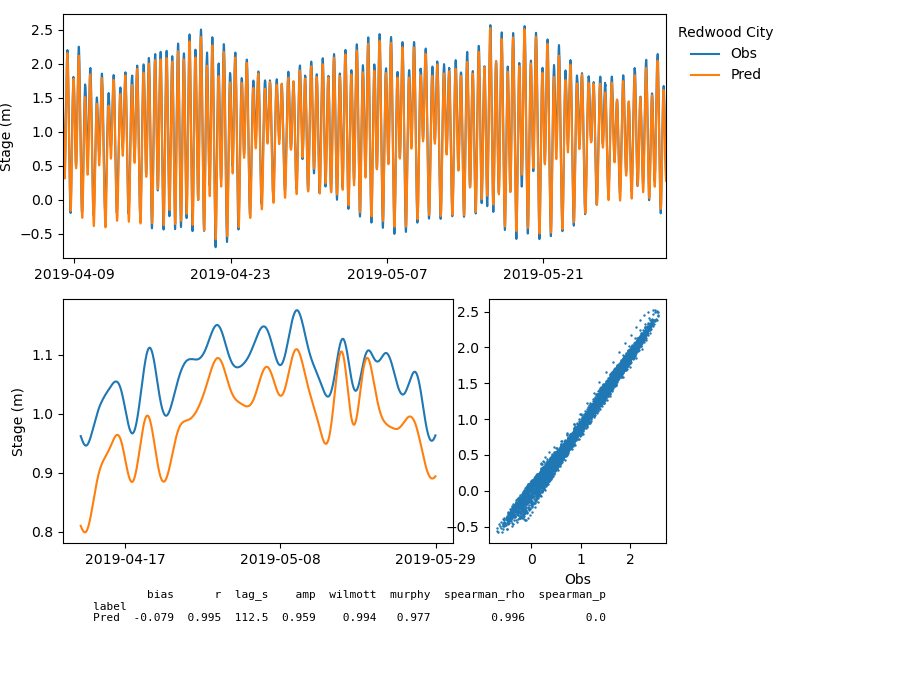

/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11455420_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11455420_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11455420_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000
Removing mean for mismatched vertical datums


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11447650_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447650_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447650_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11313433_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313433_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313433_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11337190_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337190_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11337190_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11337080_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337080_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11337080_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11336600_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11336600_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11336600_60_2019-06-01_2019-07-01.nc
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rustyh/src/stompy/stompy/model/data_comparison.py:294: RuntimeWarning: divide by zero encountered in scalar divide
  metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
/home/rustyh/src/stompy/stompy/utils.py:1172: RuntimeWarning: divide by zero encountered in scalar divide
  ms=1 - np.mean( (m-o)**2 )/np.mean( (xref-o)**2 )
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficien

Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11447905_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447905_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447905_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11447903_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447903_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447903_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11447890_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447890_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447890_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000
Removing mean for mismatched vertical datums


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11313460_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313460_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313460_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11304810_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11304810_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11304810_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000
Removing mean for mismatched vertical datums


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11312672_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11312672_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11312672_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11313315_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313315_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313315_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11447850_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447850_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447850_60_2019-06-01_2019-07-01.nc
/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:usgs_nwis:Fetching 11447830_65_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447830_65_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447830_65_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Fetching 11447830_60_2019-04-01_2019-05-01.nc


Removing mean for mismatched vertical datums
No data - skipping figure
Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447830_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447830_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


No data - skipping figure
Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)
INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-08T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


/tmp/ipykernel_1500266/503994964.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 21.
  fig.savefig(fig_fn,dpi=dpi)


In [11]:
if 1:
    fig=None
    for comp in comparisons:
        # if isinstance(comp,StageCompare) and comp.name=="Port Chicago":
        #if isinstance(comp,StageCompare) and comp.name=="Freeport":
        new_fig=comp.figure(fig=fig)
        if new_fig is None: continue
        fig=new_fig
        # print(comp.calc_metrics())
        if fig_dir is not None:
            fig_fn=os.path.join(fig_dir,comp.figure_name()+".png")
            fig.savefig(fig_fn,dpi=dpi)
            txt_fn=os.path.join(fig_dir,comp.figure_name()+".txt")
            with open(txt_fn,'wt') as fp:
                fp.write(str(comp.calc_metrics()))


In [12]:
model=runs.model[0]
grid=model.grid
shore_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 298 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [13]:
# dataframe with metrics, locations
recs=[]
for comp in comparisons:
    xy=comp.plot_xy()
    rec=dict(name=comp.name,x=xy[0],y=xy[1],cls=comp.__class__.__name__)
    # include the metrics
    rec.update(comp.calc_metrics()) 
    recs.append(rec)
comp_df=pd.DataFrame(recs)
comp_df

/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rustyh/src/stompy/stompy/model/data_comparison.py:294: RuntimeWarning: divide by zero encountered in scalar divide
  metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
/home/rustyh/src/stompy/stompy/utils.py:1172: RuntimeWarning: divide by zero encountered in scalar divide
  ms=1 - np.mean( (m-o)**2 )/np.mean( (xref-o)**2 )
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,name,x,y,cls,bias,r,lag,lag_s,amp,wilmott,murphy,spearman_rho,spearman_p,error
0,Rio Vista (SRV),615117.0,4224383.0,StageCompare,-0.375563,0.980040,-1 days +23:59:00,-60.0,0.883962,0.755272,-0.271022,0.980513,0.0,NaN
1,Rio Vista (SRV),615232.941,4224588.2913,FlowCompare,-79.985524,0.983103,-1 days +23:49:30,-630.0,1.033928,0.990794,0.962203,0.987621,0.0,NaN
2,Freeport,630728.0,4257433.0,StageCompare,NaN,0.997595,0 days 00:41:30,2490.0,0.749889,0.978368,0.933837,0.993249,0.0,NaN
3,Freeport,630579.5147,4257482.9321,FlowCompare,7.999067,0.997484,0 days 00:52:00,3120.0,1.005104,0.998641,0.994541,0.992142,0.0,NaN
4,RYI (near match),616561.0,4230315.0,StageCompare,-1.491431,0.979624,0 days 00:02:30,150.0,0.930761,0.312839,-19.899213,0.980239,0.0,NaN
5,Dutch Slough,616873.419,4208070.624,StageCompare,-0.283732,0.974963,-1 days +23:41:00,-1140.0,0.956828,0.805992,0.029610,0.975264,0.0,NaN
6,Dutch Slough,616873.419,4208070.624,FlowCompare,-6.750164,0.965750,-1 days +23:33:07.500000,-1612.5,0.889547,0.978777,0.925294,0.945018,0.0,NaN
7,Jersey Point,614542.562,4212134.93,StageCompare,-0.243209,0.976115,-1 days +23:46:22.500000,-817.5,0.947802,0.840875,0.257973,0.975824,0.0,NaN
8,Jersey Point,614542.562,4212134.93,FlowCompare,-166.623580,0.965773,-1 days +23:31:22.500000,-1717.5,0.815782,0.971395,0.906957,0.969203,0.0,NaN
9,Threemile Slough,615245.377,4218025.111,StageCompare,-0.292611,0.978329,-1 days +23:47:22.500000,-757.5,0.949403,0.797858,-0.024251,0.978327,0.0,NaN


In [14]:
# Map showing stage calibration across the domain
def fig_stations(comp_df,hue=None,label='name',clim=None,fmt="%s",
                 negative_parens=False,cls=None, nan_text="",
                 fontsize=8):
    fig,ax=plt.subplots()
    plot_wkb.plot_wkb(shore_poly,ax=ax,ec='0.7',lw=0.5,fc='0.9')
    fig.subplots_adjust(0,0,1,1)

    ax.axis('equal')
    ax.set_adjustable('datalim')
    ax.axis("off")

    if cls is not None:
        subset=comp_df[ comp_df.cls==cls ]
    else:
        subset=comp_df
        
    plotted={}
        
    for rec in subset.itertuples():
        if np.isnan(rec.x): continue
        if rec.name in plotted: continue
        plotted[rec.name]=1
        ax.plot(rec.x,rec.y,'ro',ms=3)
        if label:
            v=getattr(rec,label)
            try:
                is_nan = np.isnan(v)
            except TypeError:
                is_nan = False
            if is_nan:
                s=nan_text
            elif negative_parens and v<0:
                s='(%s)'%( fmt%(-v))
            else:
                s=fmt%v
            ax.text(rec.x,rec.y,s,fontsize=fontsize)

    zoom=[ subset.x.min(), subset.x.max(), subset.y.min(), subset.y.max()]
    ax.axis(utils.expand_xxyy(zoom,0.2))
    plot_utils.reduce_text_overlap(fig.axes[0])
    return fig

<IPython.core.display.Javascript object>


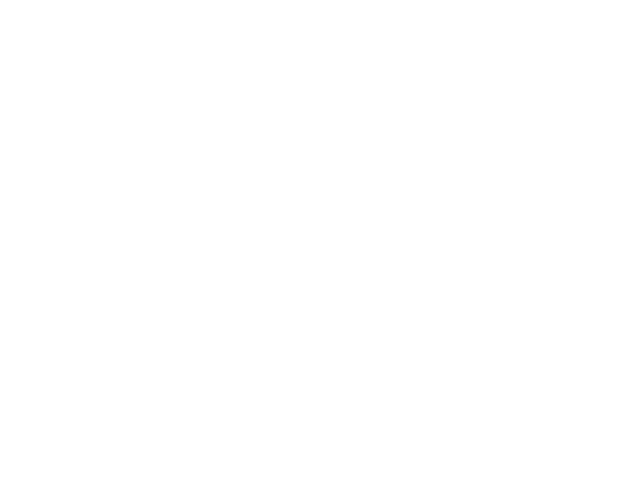

In [15]:
# Station locations with names
fig=fig_stations(comp_df,cls=None,fontsize=8) 

<IPython.core.display.Javascript object>


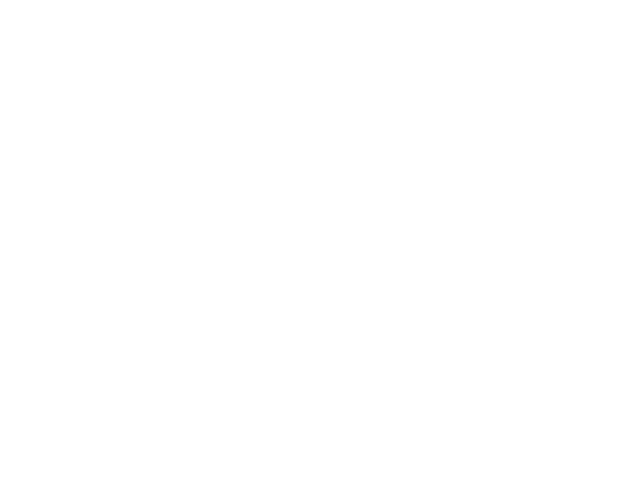

In [16]:
fig=fig_stations(comp_df,cls='StageCompare') 

if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"stage_stations.png")
    fig.savefig(fig_fn,dpi=dpi)


<IPython.core.display.Javascript object>


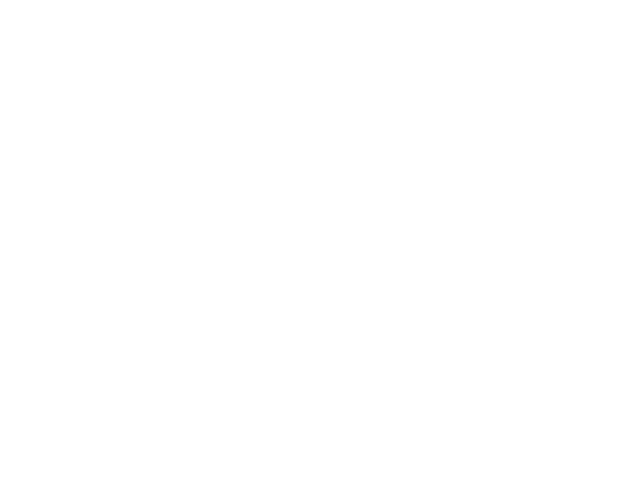

In [17]:
# WSE amplitude
# v011: amplitude acceptable throughout the Bay. Too strong
# in the W and S Delta, then weak going up mainstem Sac. DCC too strong.ma

fig=fig_stations(comp_df,label='amp',fmt="%.3f",cls="StageCompare") 
if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"stage_amplitude.png")
    fig.savefig(fig_fn,dpi=dpi)


<IPython.core.display.Javascript object>


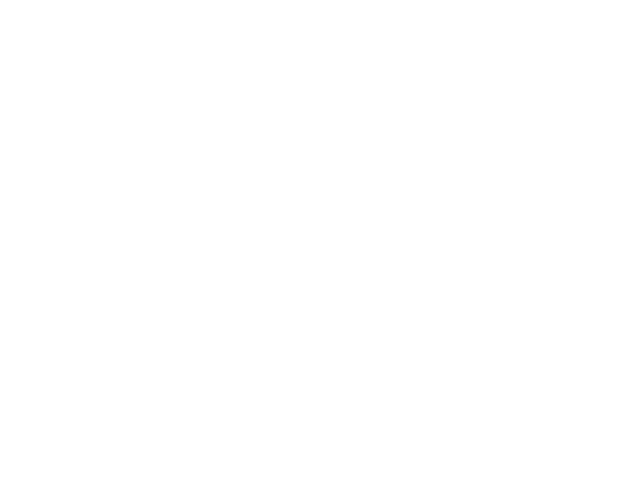

In [18]:
# WSE lag - SF is 1470s late, but propagation appears too fast
# through the Bay.
# Switched to PR tides, and now it's 585s early at SF, though amplitudes
# are still pretty bad.
# v011: Adjusted PR tides for amplitude, but I got the sign wrong
#   on the lag adjustment, and it went from -585s to -1300s.
# v019: SF is 533s late, and port chicago 383s early.
# v020: A little slow into south bay, decent into North Bay.
#  and decent into western Delta. Best yet. Attenuated going south,
#  so could decrease friction. Slightly attenuated going north.
fig=fig_stations(comp_df,label='lag_s',fmt="%.0fs",cls="StageCompare",negative_parens=True)
if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"stage_lag_s.png")
    fig.savefig(fig_fn,dpi=dpi)


<IPython.core.display.Javascript object>


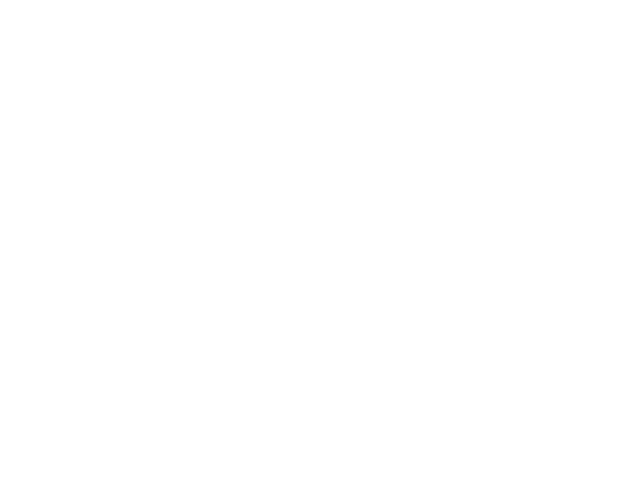

In [19]:
# WSE bias. Okay-ish in the Bay. Model is either too high in the Delta by
# 0.3m, or there is a datum issue with USGS measurements.
fig=fig_stations(comp_df,label='bias',fmt="%.2fm",cls="StageCompare",negative_parens=True)
if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"stage_bias.png")
    fig.savefig(fig_fn,dpi=dpi)


<IPython.core.display.Javascript object>


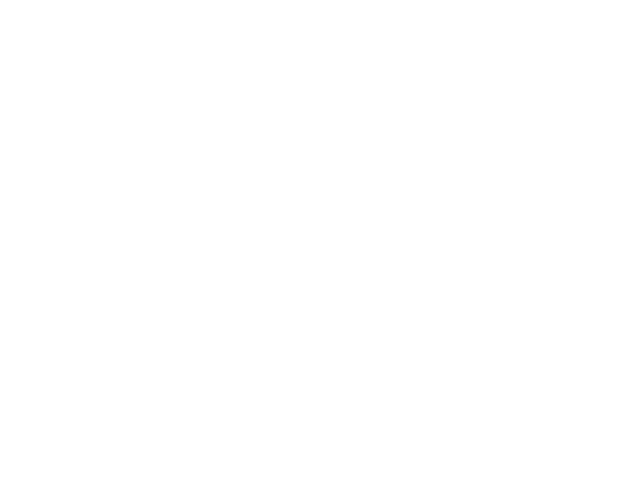

In [20]:
# Flow amplitude
# too small everywhere. This will improve with better amplitude
# on the BC.
fig=fig_stations(comp_df,label='amp',fmt="%.3f",cls="FlowCompare")
if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"flow_amp.png")
    fig.savefig(fig_fn,dpi=dpi)


<IPython.core.display.Javascript object>


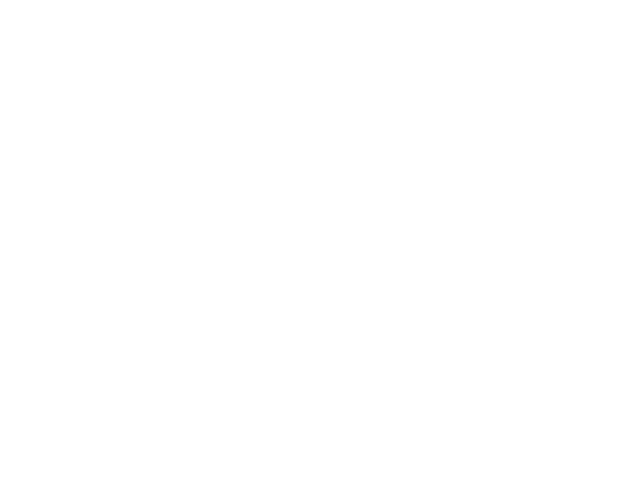

In [21]:
# Flow lag
fig=fig_stations(comp_df,label='lag_s',fmt="%.0fs",cls="FlowCompare", negative_parens=True)
if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"flow_lag_s.png")
    fig.savefig(fig_fn,dpi=dpi)


<IPython.core.display.Javascript object>


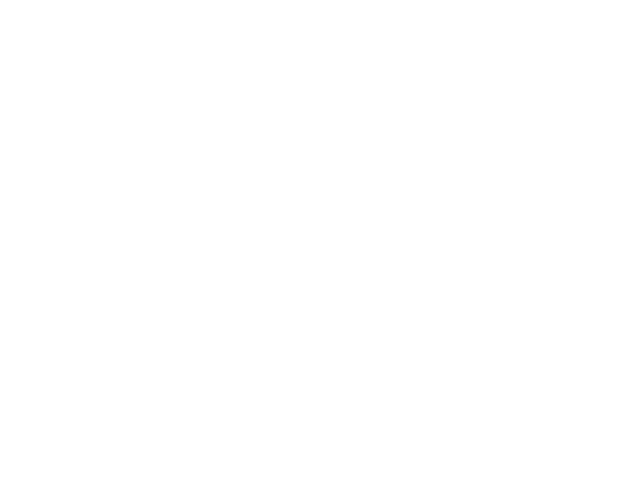

In [22]:
# Flow R
fig=fig_stations(comp_df,label='r',fmt="%.3f",cls="FlowCompare",negative_parens=True)
if fig_dir is not None:
    fig_fn=os.path.join(fig_dir,"flow_R.png")
    fig.savefig(fig_fn,dpi=dpi)


In [23]:
if fig_dir is not None:
    comp_df.to_csv(os.path.join(fig_dir,"comparisons.txt"))

In [24]:
if 0:
    #url="https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=11447650&seriesCatalogOutput=true"
    url="https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=11455420&seriesCatalogOutput=true"
    orig_df=pd.read_csv(url,sep=r"\t",comment="#",engine='python')

    # None of the stage (65) entries have a datum given for Freeport.
    # Rio Vista reports alt_datum_cd = NAVD88
    catalog_df = orig_df.iloc[1:,:]

    #  alt_va          -- Altitude of Gage/land surface
    #  alt_acy_va      -- Altitude accuracy
    #  alt_datum_cd    -- Altitude datum

    row_sel=catalog_df['parm_cd'].values=='00065'
    catalog_df.iloc[row_sel][ ['ts_id','alt_va','alt_acy_va','alt_datum_cd'] ]

    # For now, manually get the datum for each USGS stage station.
    # Everybody is NAVD88 except
    # Freeport, Prisoners Pt, and Victoria Canal.

    six.moves.reload_module(usgs_nwis)

    metas=[]
    for comp in comparisons:
        if not isinstance(comp,StageCompare): continue
        for source in comp.sources:
            if not isinstance(source, hm.NwisStageBC): continue
            meta = usgs_nwis.station_metadata(source.station,parameter=65)
            metas.append(meta)

    pd.concat(metas)[ ['station_nm','alt_datum_cd']]

In [26]:
fig_dir

'data_2d_2019_summer-v023/figures'